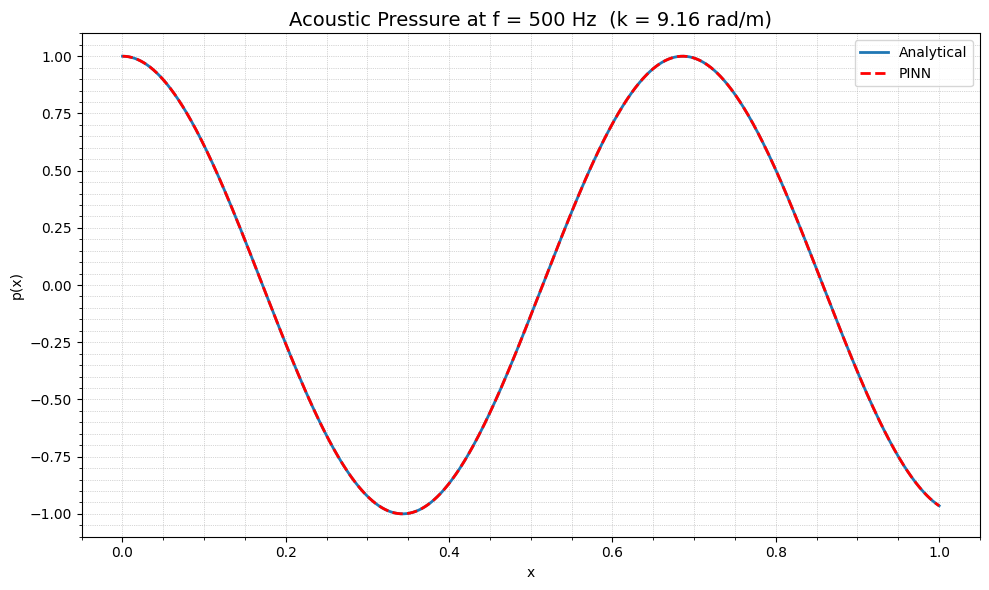

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn(frequency,
                         layers,
                         N_colloc=2000,         # ↑ increase collocation
                         c=343.0,
                         L=1.0,
                         max_iter=2000):        # ↑ allow more L-BFGS iters
    # 1) Physical parameters
    k = 2 * np.pi * frequency / c
    A = 1.0
    B = A * np.cos(k * L)

    # 2) Build the network
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.activation = torch.sin
            self.layers = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
        def forward(self, x):
            out = x
            for layer in self.layers[:-1]:
                out = self.activation(layer(out))
            return self.layers[-1](out)

    # 3) Trial solution with built‑in BCs
    def trial_solution(x, net):
        p_net = net(x)
        return (1 - x/L)*A + (x/L)*B + x*(L-x)*p_net

    # 4) Compute PDE residual p'' + k^2 p
    def helmholtz_residual(x, net):
        x_req = x.clone().detach().requires_grad_(True)
        p = trial_solution(x_req, net)
        p_x  = torch.autograd.grad(p,   x_req,
                                   grad_outputs=torch.ones_like(p),
                                   create_graph=True)[0]
        p_xx = torch.autograd.grad(p_x, x_req,
                                   grad_outputs=torch.ones_like(p_x),
                                   create_graph=True)[0]
        return p_xx + k**2 * p

    device = torch.device('cpu')
    net = PINN(layers).to(device)

    # 5) More collocation points
    x_colloc = torch.linspace(0, L, N_colloc).view(-1,1).to(device)

    # 6) Longer L-BFGS run
    optimizer = torch.optim.LBFGS(
        net.parameters(),
        lr=1.0,
        max_iter=max_iter,
        tolerance_grad=1e-9,
        tolerance_change=1e-9,
        history_size=50,
    )

    def closure():
        optimizer.zero_grad()
        res = helmholtz_residual(x_colloc, net)
        loss = torch.mean(res**2)
        loss.backward()
        return loss

    optimizer.step(closure)

    # 7) Evaluate on a fine grid
    x_plot = torch.linspace(0, L, 800).view(-1,1).to(device)
    with torch.no_grad():
        p_pred = trial_solution(x_plot, net).cpu().numpy().flatten()
    x_np    = x_plot.cpu().numpy().flatten()
    p_true  = (A * np.cos(k * x_np)
               + ((B - A * np.cos(k * L)) / np.sin(k * L))
                 * np.sin(k * x_np))

    return x_np, p_pred, p_true, k

# ————————————————
# Plot just for 1000 Hz now:
frequency = 500
x, p_pred, p_true, k_val = solve_helmholtz_pinn(
    frequency,
    layers=[1,120,120,120,1],  # ↑ a bit wider network
    N_colloc=3000,             # ↑ more points
    max_iter=2000
)

plt.figure(figsize=(10,6))
plt.plot(x, p_true, color='tab:blue', linewidth=2, label='Analytical')
plt.plot(x, p_pred, 'r--', linewidth=2, label='PINN')
plt.title(f'Acoustic Pressure at f = {frequency} Hz  (k = {k_val:.2f} rad/m)', fontsize=14)
plt.xlabel('x'); plt.ylabel('p(x)')
plt.grid(which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Randomly allocating collocation points

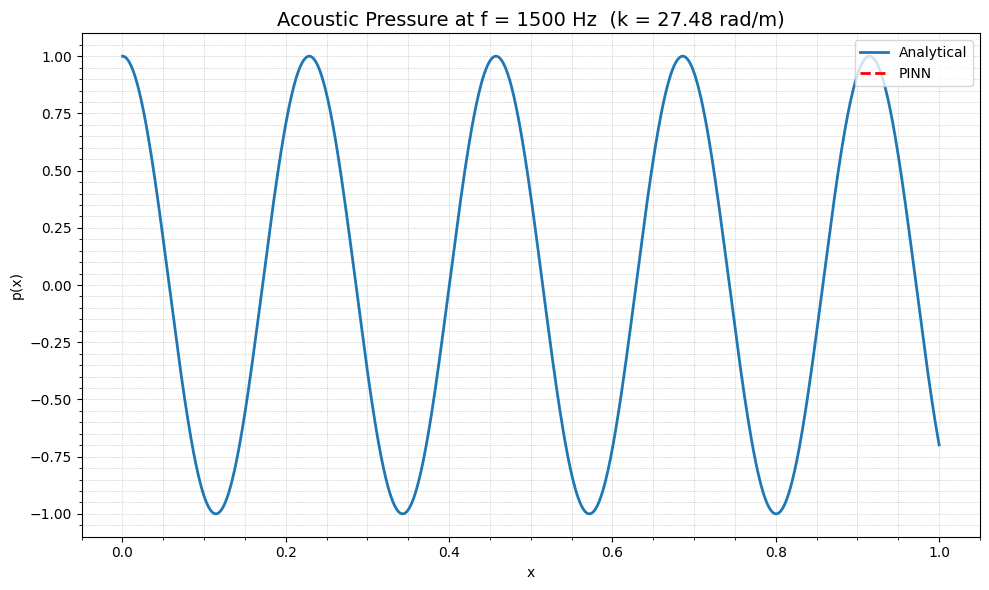

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def solve_helmholtz_pinn(frequency,
                         layers,
                         N_colloc=5000,
                         c=343.0,
                         L=1.0,
                         max_iter=3000):
    """
    Train a 1D PINN for the Helmholtz equation at a given frequency and return x, p_pred, p_true, and k.
    """
    # 1) Physical parameters
    k = 2 * np.pi * frequency / c
    A = 1.0
    B = A * np.cos(k * L)

    # 2) Build the network
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.activation = torch.sin
            self.layers = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
        def forward(self, x):
            out = x
            for layer in self.layers[:-1]:
                out = self.activation(layer(out))
            return self.layers[-1](out)

    # 3) Trial solution with built‑in BCs
    def trial_solution(x, net):
        p_net = net(x)
        return (1 - x/L)*A + (x/L)*B + x*(L - x)*p_net

    # 4) Compute PDE residual p'' + k^2 p
    def helmholtz_residual(x, net):
        x_req = x.clone().detach().requires_grad_(True)
        p = trial_solution(x_req, net)
        p_x  = torch.autograd.grad(p,   x_req,
                                   grad_outputs=torch.ones_like(p),
                                   create_graph=True)[0]
        p_xx = torch.autograd.grad(p_x, x_req,
                                   grad_outputs=torch.ones_like(p_x),
                                   create_graph=True)[0]
        return p_xx + k**2 * p

    # 5) Setup
    device = torch.device('cpu')
    net = PINN(layers).to(device)
    # Random collocation points instead of linspace
    x_colloc = torch.rand(N_colloc, 1).to(device) * L

    # 6) Longer L-BFGS run
    optimizer = torch.optim.LBFGS(
        net.parameters(),
        lr=1.0,
        max_iter=max_iter,
        tolerance_grad=1e-9,
        tolerance_change=1e-9,
        history_size=100,
    )

    def closure():
        optimizer.zero_grad()
        res = helmholtz_residual(x_colloc, net)
        loss = torch.mean(res**2)
        loss.backward()
        return loss

    optimizer.step(closure)

    # 7) Evaluate on a fine grid
    x_plot = torch.linspace(0, L, 1000).view(-1,1).to(device)
    with torch.no_grad():
        p_pred = trial_solution(x_plot, net).cpu().numpy().flatten()
    x_np    = x_plot.cpu().numpy().flatten()
    p_true  = (A * np.cos(k * x_np)
               + ((B - A * np.cos(k * L)) / np.sin(k * L))
                 * np.sin(k * x_np))

    return x_np, p_pred, p_true, k

# — Use this for 1500 Hz:
frequency = 1500
x, p_pred, p_true, k_val = solve_helmholtz_pinn(
    frequency,
    layers=[1,150,150,150,150,1],  # deeper and wider
    N_colloc=5000,
    max_iter=3000
)

plt.figure(figsize=(10,6))
plt.plot(x, p_true, color='tab:blue', linewidth=2, label='Analytical')
plt.plot(x, p_pred, 'r--', linewidth=2, label='PINN')
plt.title(f'Acoustic Pressure at f = {frequency} Hz  (k = {k_val:.2f} rad/m)', fontsize=14)
plt.xlabel('x'); plt.ylabel('p(x)')
plt.grid(which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Cosine Annealing Code (Adam+BFGS)

Epoch    1  loss = 1.058e+06  lr = 1.00e-03
Epoch  200  loss = 9.744e+04  lr = 9.76e-04
Epoch  400  loss = 4.808e+04  lr = 9.05e-04
Epoch  600  loss = 2.595e+04  lr = 7.94e-04
Epoch  800  loss = 1.552e+04  lr = 6.55e-04
Epoch 1000  loss = 1.133e+04  lr = 5.00e-04
Epoch 1200  loss = 8.429e+03  lr = 3.46e-04
Epoch 1400  loss = 6.103e+03  lr = 2.07e-04
Epoch 1600  loss = 5.246e+03  lr = 9.64e-05
Epoch 1800  loss = 4.946e+03  lr = 2.54e-05
Epoch 2000  loss = 4.897e+03  lr = 1.00e-06

Total training time: 107.98 seconds
Total collocation points used: 5000


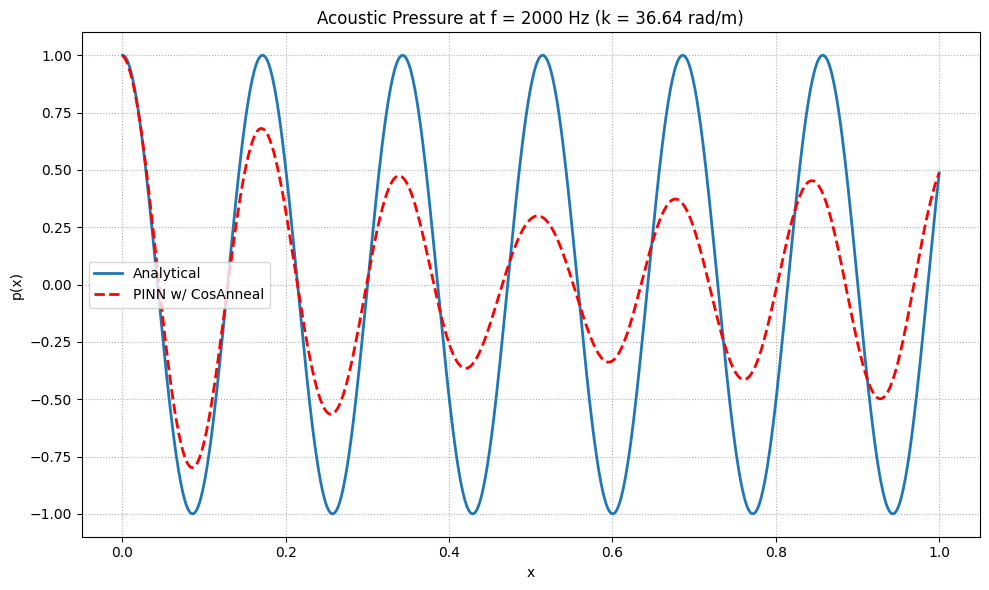

In [7]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_with_cosanneal(frequency,
                                        layers,
                                        N_colloc=5000,
                                        c=343.0,
                                        L=1.0,
                                        max_epochs=2000,
                                        eta_min=1e-5):
    # --- start timer ---
    t_start = time.perf_counter()

    # 1) Physical parameters
    k = 2 * np.pi * frequency / c
    A = 1.0
    B = A * np.cos(k * L)

    # 2) PINN definition
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.layers = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
        def forward(self, x):
            y = x
            for l in self.layers[:-1]:
                y = self.act(l(y))
            return self.layers[-1](y)

    # 3) Trial solution (enforces BCs exactly)
    def trial(x, net):
        p = net(x)
        return (1 - x / L) * A + (x / L) * B + x * (L - x) * p

    # 4) Helmholtz residual
    def residual(x, net):
        x_req = x.clone().detach().requires_grad_(True)
        p = trial(x_req, net)
        dp = torch.autograd.grad(p, x_req,
                                 grad_outputs=torch.ones_like(p),
                                 create_graph=True)[0]
        d2p = torch.autograd.grad(dp, x_req,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return d2p + k**2 * p

    device = torch.device('cpu')
    net = PINN(layers).to(device)

    # 5) Collocation points (fixed for simplicity here)
    x_colloc = torch.linspace(0, L, N_colloc, device=device).unsqueeze(-1)

    # 6) Use Adam + CosineAnnealingLR
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=max_epochs,   # length of one “half‐cosine” cycle
        eta_min=eta_min     # minimum lr at the cycle’s end
    )

    # 7) Training loop
    for epoch in range(1, max_epochs + 1):
        optimizer.zero_grad()
        res = residual(x_colloc, net)
        loss = torch.mean(res**2)
        loss.backward()
        optimizer.step()
        scheduler.step()    # update the lr via half‐cosine

        if epoch % 200 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d}  loss = {loss.item():.3e}  lr = {scheduler.get_last_lr()[0]:.2e}")

    # --- end timer ---
    t_end = time.perf_counter()
    total_time = t_end - t_start

    # Print timing and collocation info
    print(f"\nTotal training time: {total_time:.2f} seconds")
    print(f"Total collocation points used: {N_colloc}")

    # 8) Evaluation
    x_plot = torch.linspace(0, L, 800, device=device).unsqueeze(-1)
    with torch.no_grad():
        p_pred = trial(x_plot, net).cpu().numpy().flatten()

    x_np = x_plot.cpu().numpy().flatten()
    p_true = (A * np.cos(k * x_np)
              + ((B - A * np.cos(k * L)) / np.sin(k * L))
              * np.sin(k * x_np))

    return x_np, p_pred, p_true, k

# —————————————————————————
# Example for 500 Hz:
frequency = 2000
x, p_pred, p_true, k_val = solve_helmholtz_pinn_with_cosanneal(
    frequency,
    layers=[1,120,120,120,1],
    N_colloc=5000,
    max_epochs=2000,
    eta_min=1e-6
)

plt.figure(figsize=(10,6))
plt.plot(x, p_true, label='Analytical', linewidth=2)
plt.plot(x, p_pred, 'r--', label='PINN w/ CosAnneal', linewidth=2)
plt.title(f'Acoustic Pressure at f = {frequency} Hz (k = {k_val:.2f} rad/m)')
plt.xlabel('x'); plt.ylabel('p(x)')
plt.grid(True, which='both', linestyle=':')
plt.legend(); plt.tight_layout()
plt.show()


Cosine Annealing Code(BFGS Only)

Final PDE loss: 9.812e+05
Total training time: 173.51 s
Total collocation points used: 5000


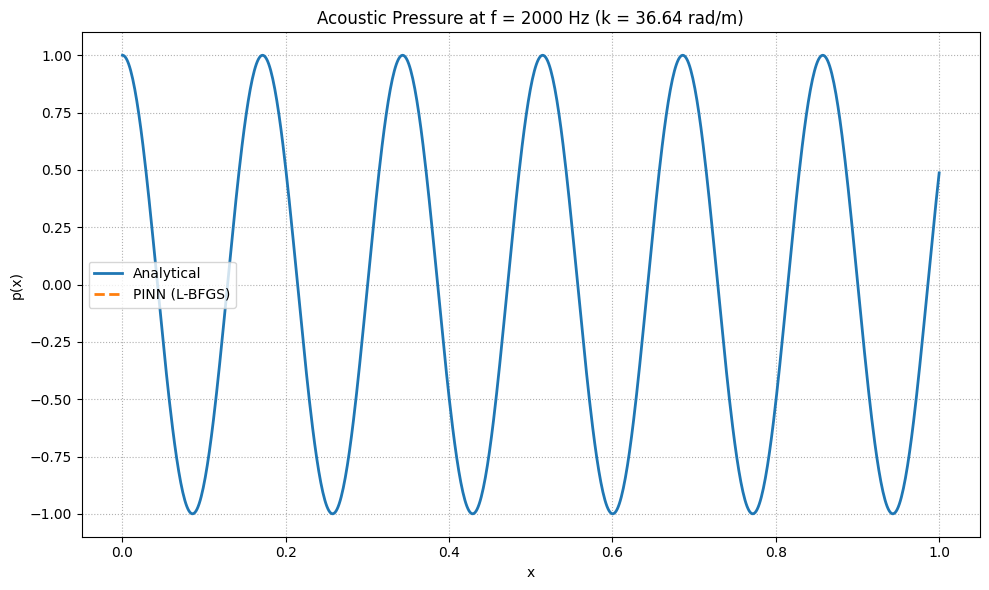

In [9]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_lbfgs(frequency,
                               layers,
                               N_colloc=5000,
                               c=343.0,
                               L=1.0,
                               max_iter=2000):
    # — Start timing
    t_start = time.perf_counter()

    # 1) Physical parameters
    k = 2 * np.pi * frequency / c
    A = 1.0
    B = A * np.cos(k * L)

    # 2) PINN definition
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.layers = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
        def forward(self, x):
            y = x
            for l in self.layers[:-1]:
                y = self.act(l(y))
            return self.layers[-1](y)

    # 3) Trial solution (enforce BCs)
    def trial(x, net):
        p = net(x)
        return (1 - x/L)*A + (x/L)*B + x*(L-x)*p

    # 4) PDE residual
    def helmholtz_residual(x, net):
        x_req = x.clone().detach().requires_grad_(True)
        p = trial(x_req, net)
        dp = torch.autograd.grad(p, x_req,
                                 grad_outputs=torch.ones_like(p),
                                 create_graph=True)[0]
        d2p = torch.autograd.grad(dp, x_req,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return d2p + k**2 * p

    device = torch.device('cpu')
    net = PINN(layers).to(device)

    # 5) Uniform grid of collocation points
    x_colloc = torch.linspace(0, L, N_colloc, device=device).unsqueeze(-1)

    # 6) L-BFGS optimizer
    optimizer = torch.optim.LBFGS(
        net.parameters(),
        lr=1.0,
        max_iter=max_iter,
        tolerance_grad=1e-9,
        tolerance_change=1e-9,
        history_size=50,
    )

    # 7) Closure for L-BFGS
    def closure():
        optimizer.zero_grad()
        res = helmholtz_residual(x_colloc, net)
        loss = torch.mean(res**2)
        loss.backward()
        return loss

    # 8) Run the L-BFGS solve
    final_loss = optimizer.step(closure).item()

    # 9) Stop timing
    t_end = time.perf_counter()
    total_time = t_end - t_start

    print(f"Final PDE loss: {final_loss:.3e}")
    print(f"Total training time: {total_time:.2f} s")
    print(f"Total collocation points used: {N_colloc}")

    # 10) Evaluate solution
    x_plot = torch.linspace(0, L, 800, device=device).unsqueeze(-1)
    with torch.no_grad():
        p_pred = trial(x_plot, net).cpu().numpy().flatten()

    x_np   = x_plot.cpu().numpy().flatten()
    p_true = (A * np.cos(k*x_np)
              + ((B - A*np.cos(k*L)) / np.sin(k*L)) * np.sin(k*x_np))

    return x_np, p_pred, p_true, k

# ——————— Example for 2000 Hz ———————
frequency = 2000
x, p_pred, p_true, k_val = solve_helmholtz_pinn_lbfgs(
    frequency,
    layers=[1,120,120,120,1],
    N_colloc=5000,    # you may need higher N_colloc at high freq
    max_iter=2000
)

plt.figure(figsize=(10,6))
plt.plot(x, p_true,   label='Analytical',  linewidth=2)
plt.plot(x, p_pred, '--', label='PINN (L-BFGS)', linewidth=2)
plt.title(f'Acoustic Pressure at f = {frequency} Hz (k = {k_val:.2f} rad/m)')
plt.xlabel('x'); plt.ylabel('p(x)')
plt.grid(True, which='both', linestyle=':')
plt.legend(); plt.tight_layout()
plt.show()


Trying to fix "no output at higher frequencies" issue
Key changes are:

    Separated physical coordinate x0 (used in the trial solution for BCs) from the network input x_hat.

    Applied the chain rule: derivatives w.r.t. network input x_hat are converted to physical derivatives by multiplying by (2/L)2.

    Kept only L-BFGS, Xavier initialization, and sin activations

With this fix we should no longer see NaNs

LBFGS closure call 500: loss = 1.762e+02
LBFGS closure call 1000: loss = 1.303e+02
LBFGS closure call 1500: loss = 1.040e+02
LBFGS closure call 2000: loss = 9.122e+01

Final PDE loss: 5.156e+02
Time elapsed: 49.0s | Collocation points: 2000
Total LBFGS closure calls: 2000
Relative error δp = 5.321e-01


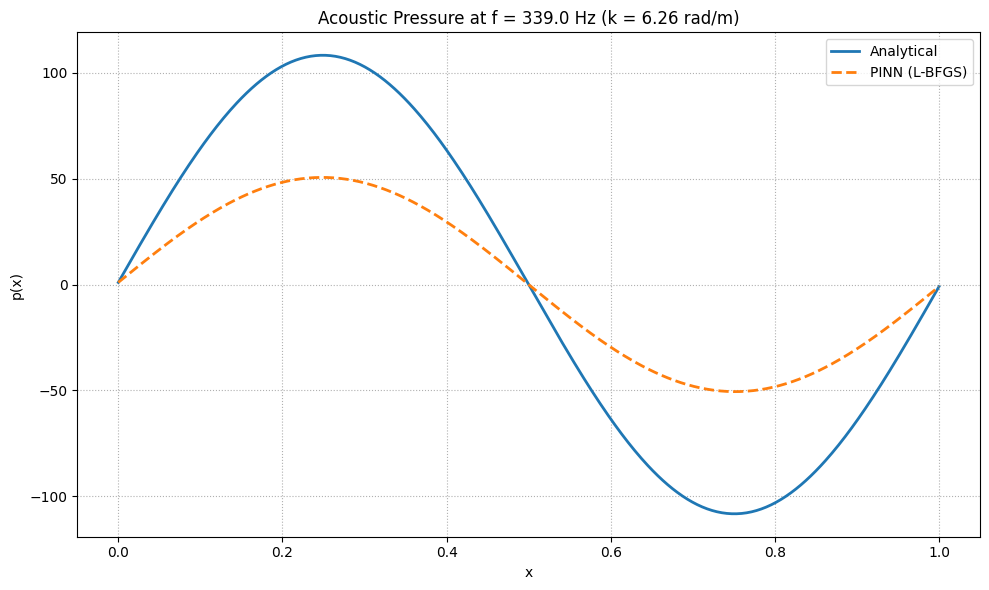

In [14]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_lbfgs(k,
                               A,
                               B,
                               layers,
                               N_colloc=2000,
                               c=340.0,
                               L=1.0,
                               max_iter=2000,
                               lr=0.1,
                               N_test=500):
    t0 = time.perf_counter()

    # 1) Network definition + Xavier init
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.layers = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.layers:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.layers[:-1]:
                y = self.act(lin(y))
            return self.layers[-1](y)

    net = PINN(layers)

    # 2) Prepare collocation points (exclude x=0 and x=L)
    x0_full = torch.linspace(0, L, N_colloc + 2)
    x0 = x0_full[1:-1].unsqueeze(-1)
    x_hat = 2 * (x0 / L) - 1

    # 3) Trial solution enforces BC at x0
    def trial(x_hat_req):
        x_phys = (x_hat_req + 1) * (L / 2)
        p_net = net(x_hat_req)
        return (1 - x_phys / L) * A + (x_phys / L) * B + x_phys * (L - x_phys) * p_net

    # 4) Residual in normalized coordinates
    def residual(x_hat_req):
        p = trial(x_hat_req)
        dp  = torch.autograd.grad(p, x_hat_req,
                                  grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]
        d2p = torch.autograd.grad(dp, x_hat_req,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return (2.0 / L) ** 2 * d2p + k ** 2 * p

    # 5) Move to device
    device = torch.device('cpu')
    net.to(device)
    x_hat = x_hat.to(device)

    # 6) L-BFGS optimizer
    optimizer = torch.optim.LBFGS(
        net.parameters(),
        lr=lr,
        max_iter=max_iter,
        tolerance_grad=1e-12,
        tolerance_change=1e-14,
        history_size=50,
    )

    # counter to track closure calls
    lf_counter = {"count": 0}

    # 7) Closure that computes loss and prints every 500 calls
    def closure():
        optimizer.zero_grad()
        x_in = x_hat.clone().detach().requires_grad_(True)
        res = residual(x_in)
        loss = torch.mean(res ** 2)
        if not torch.isfinite(loss):
            raise RuntimeError(f"Non-finite loss encountered: {loss.item():.3e}")
        loss.backward()

        lf_counter["count"] += 1
        if lf_counter["count"] % 500 == 0:
            print(f"LBFGS closure call {lf_counter['count']}: loss = {loss.item():.3e}")

        return loss

    # 8) Run L-BFGS
    final_loss = optimizer.step(closure).item()

    # 9) Timing and summary
    elapsed = time.perf_counter() - t0
    print(f"\nFinal PDE loss: {final_loss:.3e}")
    print(f"Time elapsed: {elapsed:.1f}s | Collocation points: {N_colloc}")
    print(f"Total LBFGS closure calls: {lf_counter['count']}")

    # 10) Evaluate on fine grid [0,L]
    x_plot = torch.linspace(0, L, 500).unsqueeze(-1)
    x_hat_plot = 2 * (x_plot / L) - 1
    with torch.no_grad():
        p_pred = trial(x_hat_plot.to(device)).cpu().numpy().flatten()

    x_np   = x_plot.numpy().flatten()
    p_true = (A * np.cos(k * x_np)
              + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_np))

    # 11) Compute relative error δp on N_test points
    x_test = np.linspace(0, L, N_test)
    p_test_true = (A * np.cos(k * x_test)
                   + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_test))

    xh_test = 2 * (x_test / L) - 1
    xh_tensor = torch.from_numpy(xh_test.reshape(-1,1).astype(np.float32)).to(device)
    with torch.no_grad():
        p_test_pred = trial(xh_tensor).cpu().numpy().flatten()

    num   = np.sum((p_test_pred - p_test_true)**2)
    denom = np.sum((p_test_true)**2)
    delta_p = np.sqrt(num/denom)
    print(f"Relative error δp = {delta_p:.3e}")

    return x_np, p_pred, p_true, k, delta_p

if __name__ == "__main__":
    # Example usage at 330 Hz
    c = 340.0
    frequency = 339.0
    k_val = 2 * np.pi * frequency / c
    A_val = 1.0
    B_val = -1.0

    x, p_pred, p_true, k_out, delta_p = solve_helmholtz_pinn_lbfgs(
        k_val,
        A_val,
        B_val,
        layers=[1, 120, 120, 120, 1],
        N_colloc=2000,
        L=1.0,
        max_iter=2000,
        lr=0.1,
        N_test=1000
    )

    # Plot analytical vs PINN
    plt.figure(figsize=(10,6))
    plt.plot(x, p_true,  label='Analytical', linewidth=2)
    plt.plot(x, p_pred, '--', label='PINN (L-BFGS)', linewidth=2)
    plt.title(f'Acoustic Pressure at f = {frequency} Hz (k = {k_out:.2f} rad/m)')
    plt.xlabel('x'); plt.ylabel('p(x)')
    plt.grid(which='both', linestyle=':')
    plt.legend(); plt.tight_layout()
    plt.show()


Applying Adaptive Sampling Strategy + Cosine Annealing to above code

Epoch 1/2000  loss=1.038e+06  lr=5.00e-01  η=1.00
Epoch 200/2000  loss=0.000e+00  lr=4.88e-01  η=0.00
Epoch 400/2000  loss=0.000e+00  lr=4.52e-01  η=0.00
Epoch 600/2000  loss=0.000e+00  lr=3.97e-01  η=0.00
Epoch 800/2000  loss=0.000e+00  lr=3.27e-01  η=0.00
Epoch 1000/2000  loss=0.000e+00  lr=2.50e-01  η=0.00
Epoch 1200/2000  loss=0.000e+00  lr=1.73e-01  η=0.00
Epoch 1400/2000  loss=0.000e+00  lr=1.03e-01  η=0.00
Epoch 1600/2000  loss=0.000e+00  lr=4.77e-02  η=0.00
Epoch 1800/2000  loss=0.000e+00  lr=1.22e-02  η=0.00
Epoch 2000/2000  loss=0.000e+00  lr=1.00e-06  η=0.00

Done in 202.4s | collocation=5000 | final loss=0.000e+00


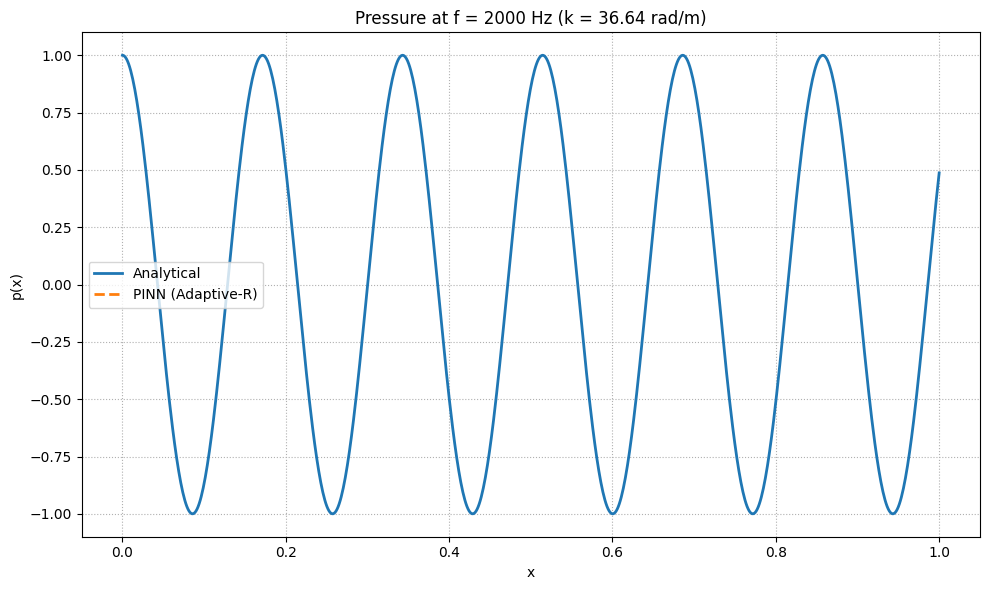

In [34]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_lbfgs_prog_adaptive(frequency,
                                            layers,
                                            N_colloc=5000,
                                            c=343.0,
                                            L=1.0,
                                            max_epochs=2000,
                                            base_lr=0.5,
                                            eta_min=1e-6,
                                            gamma=0.9,
                                            pool_size=20000,
                                            resample_every=10,
                                            T=200):
    """
    PINN solver with progressive adaptive-R sampling (PDE residual)
    plus manual cosine-annealing schedule, using L-BFGS optimizer.
    """
    t0 = time.perf_counter()

    # Physical parameters
    k = 2 * np.pi * frequency / c
    A = 1.0
    B = A * np.cos(k * L)

    # 1) Network definition + Xavier init
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.layers = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.layers:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.layers[:-1]:
                y = self.act(lin(y))
            return self.layers[-1](y)

    net = PINN(layers).to(torch.device('cpu'))

    # 2) Trial solution & residual definitions
    def trial(xh):
        x_phys = (xh + 1) * (L / 2)
        p_net = net(xh)
        return (1 - x_phys / L) * A + (x_phys / L) * B + x_phys * (L - x_phys) * p_net

    def residual(xh):
        xh_req = xh.clone().detach().requires_grad_(True)
        p = trial(xh_req)
        dp = torch.autograd.grad(p, xh_req, torch.ones_like(p), create_graph=True)[0]
        d2p = torch.autograd.grad(dp, xh_req, torch.ones_like(dp), create_graph=True)[0]
        return (2.0 / L)**2 * d2p + k**2 * p

    # 3) Initialize adaptive distribution proxy
    P_prev = None

    # 4) L-BFGS optimizer setup
    optimizer = torch.optim.LBFGS(
        net.parameters(),
        lr=base_lr,
        max_iter=1,
        tolerance_grad=1e-9,
        tolerance_change=1e-12,
        history_size=50
    )

    def closure(xh):
        optimizer.zero_grad()
        res = residual(xh)
        # sanitize residual
        res = torch.nan_to_num(res, nan=0.0, posinf=1e6, neginf=-1e6)
        loss = torch.mean(res**2)
        if torch.isnan(loss) or torch.isinf(loss):
            loss = torch.tensor(1e6, requires_grad=True)
        loss.backward()
        return loss

    # 5) Training loop
    for epoch in range(1, max_epochs + 1):
        if epoch % resample_every == 0 or epoch == 1:
            x_pool0 = torch.rand(pool_size, 1) * L
            x_pool = 2 * (x_pool0 / L) - 1
            r_pool = torch.abs(residual(x_pool).detach())
            w = r_pool.cpu().numpy().flatten() + 1e-8
            p_pool = w / w.sum()
            if P_prev is None:
                P_prev = p_pool
            else:
                combined = p_pool + gamma * P_prev
                combined = np.nan_to_num(combined, nan=0.0)
                total = combined.sum()
                if total <= 0:
                    combined = np.ones_like(combined) / combined.size
                else:
                    combined = combined / total
                P_prev = combined

        Tc = (epoch - 1) % T
        eta = 0.5 * (1 + np.cos(np.pi * Tc / T))

        n_uni = int(np.ceil(eta * N_colloc))
        n_adapt = N_colloc - n_uni
        x_uni0 = torch.rand(n_uni, 1) * L
        if P_prev is not None and n_adapt > 0:
            idx = np.random.choice(pool_size, size=n_adapt, p=P_prev)
            x_adapt0 = x_pool0[idx]
            x0 = torch.cat([x_uni0, x_adapt0], dim=0)
        else:
            x0 = x_uni0
        x_hat = 2 * (x0 / L) - 1

        lr = eta_min + 0.5 * (base_lr - eta_min) * (1 + np.cos(np.pi * epoch / max_epochs))
        optimizer.param_groups[0]['lr'] = lr

        loss = optimizer.step(lambda: closure(x_hat)).item()
        if epoch == 1 or epoch % 200 == 0 or epoch == max_epochs:
            print(f"Epoch {epoch}/{max_epochs}  loss={loss:.3e}  lr={lr:.2e}  η={eta:.2f}")

    elapsed = time.perf_counter() - t0
    print(f"\nDone in {elapsed:.1f}s | collocation={N_colloc} | final loss={loss:.3e}")

    # 6) Evaluation
    x_plot0 = torch.linspace(0, L, 800).unsqueeze(-1)
    x_hat_plot = 2 * (x_plot0 / L) - 1
    with torch.no_grad():
        p_pred = trial(x_hat_plot).cpu().numpy().flatten()
    x_np = x_plot0.cpu().numpy().flatten()
    p_true = (
        A * np.cos(k * x_np)
        + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_np)
    )
    return x_np, p_pred, p_true, k

if __name__ == "__main__":
    # Example usage for 2000 Hz
    frequency = 2000
    x, p_pred, p_true, k_val = solve_helmholtz_pinn_lbfgs_prog_adaptive(
        frequency,
        layers=[1, 120, 120, 120, 1],
        N_colloc=5000,
        max_epochs=2000,
        base_lr=0.5,
        eta_min=1e-6,
        gamma=0.9,
        pool_size=20000,
        resample_every=10,
        T=200
    )
    plt.figure(figsize=(10, 6))
    plt.plot(x, p_true, label='Analytical', linewidth=2)
    plt.plot(x, p_pred, '--', label='PINN (Adaptive-R)', linewidth=2)
    plt.title(f'Pressure at f = {frequency} Hz (k = {k_val:.2f} rad/m)')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    plt.grid(which='both', linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.show()


Applying Cosine Annealing to above code(LBFGS only)

Epoch    1/2000  loss=9.779e+04  lr=1.00e+00
Epoch  200/2000  loss=3.195e-01  lr=9.76e-01
Epoch  400/2000  loss=2.408e-03  lr=9.05e-01
Epoch  600/2000  loss=1.372e-03  lr=7.94e-01
Epoch  800/2000  loss=9.286e-04  lr=6.55e-01
Epoch 1000/2000  loss=4.695e-04  lr=5.00e-01
Epoch 1200/2000  loss=2.005e-04  lr=3.45e-01
Epoch 1400/2000  loss=1.750e-04  lr=2.06e-01
Epoch 1600/2000  loss=1.749e-04  lr=9.55e-02
Epoch 1800/2000  loss=1.751e-04  lr=2.45e-02
Epoch 2000/2000  loss=1.765e-04  lr=1.00e-06

Done in 108.8s | collocation=5000 | final loss=1.765e-04


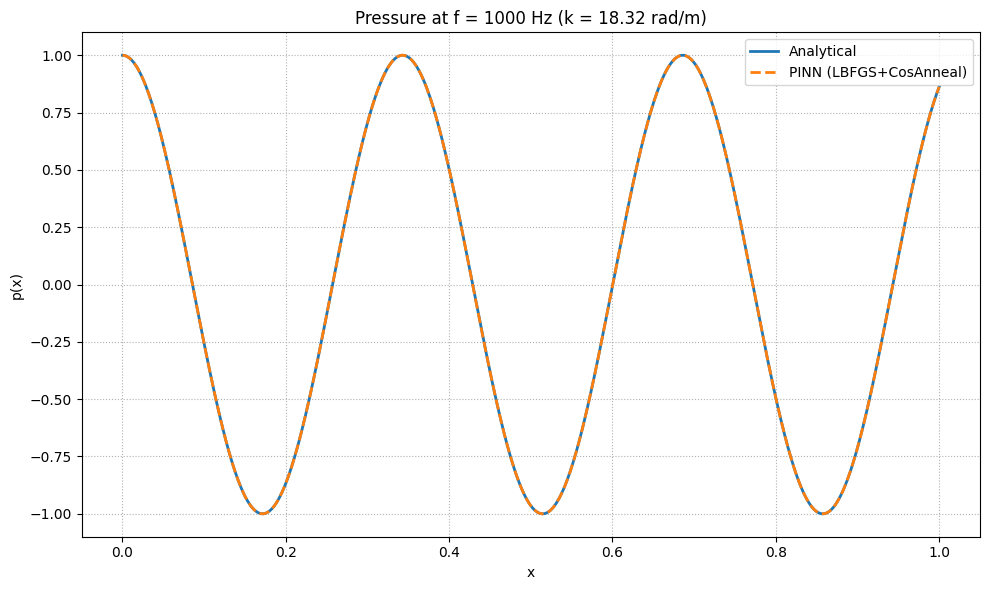

In [25]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_lbfgs_cosanneal(frequency,
                                         layers,
                                         N_colloc=5000,
                                         c=343.0,
                                         L=1.0,
                                         max_epochs=2000,
                                         base_lr=1.0,
                                         eta_min=1e-6):
    t0 = time.perf_counter()

    # Physical parameters
    k = 2 * np.pi * frequency / c
    A = 1.0
    B = A * np.cos(k * L)

    # 1) PINN definition + Xavier init
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.layers = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.layers:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.layers[:-1]:
                y = self.act(lin(y))
            return self.layers[-1](y)

    net = PINN(layers)

    # 2) Collocation points (physical and scaled)
    x0     = torch.linspace(0, L, N_colloc).unsqueeze(-1)      # physical
    x_hat  = 2 * (x0 / L) - 1                                  # scaled for network

    # 3) Trial solution (enforce BCs)
    def trial(xh):
        x_phys = (xh + 1) * (L/2)
        p_net  = net(xh)
        return (1 - x_phys/L)*A + (x_phys/L)*B + x_phys*(L-x_phys)*p_net

    # 4) Residual with chain rule
    def residual(xh):
        xh_req = xh.clone().detach().requires_grad_(True)
        p      = trial(xh_req)
        dp     = torch.autograd.grad(p, xh_req,
                                     grad_outputs=torch.ones_like(p),
                                     create_graph=True)[0]
        d2p    = torch.autograd.grad(dp, xh_req,
                                     grad_outputs=torch.ones_like(dp),
                                     create_graph=True)[0]
        # d²/dx_phys² = ((2/L)²) d²/dx_hat²
        return (2.0/L)**2 * d2p + k**2 * p

    # Move to device
    device = torch.device('cpu')
    net.to(device)
    x_hat = x_hat.to(device)

    # 5) LBFGS optimizer with one step per call
    optimizer = torch.optim.LBFGS(
        net.parameters(),
        lr=base_lr,
        max_iter=1,             # one line-search step per epoch
        tolerance_grad=1e-9,
        tolerance_change=1e-12,
        history_size=50,
    )

    def closure():
        optimizer.zero_grad()
        res  = residual(x_hat)
        loss = torch.mean(res**2)
        if not torch.isfinite(loss):
            raise RuntimeError(f"Non-finite loss: {loss}")
        loss.backward()
        return loss

    # 6) Training loop with manual cosine annealing
    for epoch in range(1, max_epochs+1):
        # compute annealed LR
        lr = eta_min + 0.5*(base_lr - eta_min)*(1 + np.cos(np.pi*epoch/max_epochs))
        optimizer.param_groups[0]['lr'] = lr

        # one L-BFGS step
        loss = optimizer.step(closure).item()

        # log
        if epoch == 1 or epoch % 200 == 0 or epoch == max_epochs:
            print(f"Epoch {epoch:4d}/{max_epochs}  loss={loss:.3e}  lr={lr:.2e}")

    t_end = time.perf_counter()
    print(f"\nDone in {t_end - t0:.1f}s | collocation={N_colloc} | final loss={loss:.3e}")

    # 7) Evaluate
    x_plot    = torch.linspace(0, L, 800).unsqueeze(-1)
    x_hat_plot= 2*(x_plot/L) - 1
    with torch.no_grad():
        p_pred = trial(x_hat_plot.to(device)).cpu().numpy().flatten()
    x_np = x_plot.numpy().flatten()
    p_true = (A*np.cos(k*x_np) 
              + ((B - A*np.cos(k*L))/np.sin(k*L))*np.sin(k*x_np))

    return x_np, p_pred, p_true, k

# Example usage at 1000 Hz
frequency = 1000
x, p_pred, p_true, k_val = solve_helmholtz_pinn_lbfgs_cosanneal(
    frequency,
    layers=[1,120,120,120,1],
    N_colloc=5000,
    max_epochs=2000,
    base_lr=1.0,
    eta_min=1e-6
)

# Plot result
plt.figure(figsize=(10,6))
plt.plot(x, p_true, label='Analytical', linewidth=2)
plt.plot(x, p_pred, '--', label='PINN (LBFGS+CosAnneal)', linewidth=2)
plt.title(f'Pressure at f = {frequency} Hz (k = {k_val:.2f} rad/m)')
plt.xlabel('x'); plt.ylabel('p(x)')
plt.grid(which='both', linestyle=':')
plt.legend(); plt.tight_layout()
plt.show()
